In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from torchinfo import summary
from adopt import ADOPT
import os

In [2]:
os.listdir("../BIGDATA")

['jandata.csv', 'febdata.csv']

In [3]:
def collect_data(directory_path):
  
    data = pd.read_csv(directory_path + os.listdir(directory_path)[0])
    
    for i in range(1,len(os.listdir(directory_path))):
        data_intermediate = pd.read_csv(directory_path + os.listdir(directory_path)[i])
        data_intermediate.rename(columns={'Unnamed: 0': 'time'}, inplace=True)
        data_intermediate.drop(['LQFRAC'], axis = 1, inplace = True)
        data = pd.concat([data, data_intermediate], axis = 0)

    
    return data 

In [4]:
data = collect_data("../BIGDATA/")

In [5]:
print(data.shape)
print(data.columns)

(1441440, 56)
Index(['time', 'comid', 'catid', 'du', 'pair_id', 'U2D', 'V2D', 'LWDOWN',
       'RAINRATE', 'T2D', 'Q2D', 'PSFC', 'SWDOWN', 'streamflow',
       'elevation_mean', 'slope_mean', 'impervious_mean', 'aspect_c_mean',
       'twi_dist_4', 'X', 'Y', 'gw_Coeff', 'gw_Zmax', 'gw_Expon',
       'bexp_soil_layers_stag=1', 'bexp_soil_layers_stag=2',
       'bexp_soil_layers_stag=3', 'bexp_soil_layers_stag=4', 'ISLTYP',
       'IVGTYP', 'dksat_soil_layers_stag=1', 'dksat_soil_layers_stag=2',
       'dksat_soil_layers_stag=3', 'dksat_soil_layers_stag=4',
       'psisat_soil_layers_stag=1', 'psisat_soil_layers_stag=2',
       'psisat_soil_layers_stag=3', 'psisat_soil_layers_stag=4', 'cwpvt',
       'mfsno', 'mp', 'quartz_soil_layers_stag=1', 'quartz_soil_layers_stag=2',
       'quartz_soil_layers_stag=3', 'quartz_soil_layers_stag=4', 'refkdt',
       'slope', 'smcmax_soil_layers_stag=1', 'smcmax_soil_layers_stag=2',
       'smcmax_soil_layers_stag=3', 'smcmax_soil_layers_stag=4',
     

In [ ]:
# data = pd.read_csv("../BIGDATA/jandata.csv")
# print(data.shape)

(744744, 56)


In [6]:
print(f"The number of features available to us: {data.shape[1]}")
print(data.columns)

The number of features available to us: 56
Index(['time', 'comid', 'catid', 'du', 'pair_id', 'U2D', 'V2D', 'LWDOWN',
       'RAINRATE', 'T2D', 'Q2D', 'PSFC', 'SWDOWN', 'streamflow',
       'elevation_mean', 'slope_mean', 'impervious_mean', 'aspect_c_mean',
       'twi_dist_4', 'X', 'Y', 'gw_Coeff', 'gw_Zmax', 'gw_Expon',
       'bexp_soil_layers_stag=1', 'bexp_soil_layers_stag=2',
       'bexp_soil_layers_stag=3', 'bexp_soil_layers_stag=4', 'ISLTYP',
       'IVGTYP', 'dksat_soil_layers_stag=1', 'dksat_soil_layers_stag=2',
       'dksat_soil_layers_stag=3', 'dksat_soil_layers_stag=4',
       'psisat_soil_layers_stag=1', 'psisat_soil_layers_stag=2',
       'psisat_soil_layers_stag=3', 'psisat_soil_layers_stag=4', 'cwpvt',
       'mfsno', 'mp', 'quartz_soil_layers_stag=1', 'quartz_soil_layers_stag=2',
       'quartz_soil_layers_stag=3', 'quartz_soil_layers_stag=4', 'refkdt',
       'slope', 'smcmax_soil_layers_stag=1', 'smcmax_soil_layers_stag=2',
       'smcmax_soil_layers_stag=3', 'smcm

In [7]:
data.drop(['bexp_soil_layers_stag=2',
       'bexp_soil_layers_stag=3', 'bexp_soil_layers_stag=4', 'dksat_soil_layers_stag=2',
       'dksat_soil_layers_stag=3', 'dksat_soil_layers_stag=4', 'psisat_soil_layers_stag=2',
       'psisat_soil_layers_stag=3', 'psisat_soil_layers_stag=4', 'quartz_soil_layers_stag=2',
       'quartz_soil_layers_stag=3', 'quartz_soil_layers_stag=4', 'smcmax_soil_layers_stag=2',
       'smcmax_soil_layers_stag=3', 'smcmax_soil_layers_stag=4','smcwlt_soil_layers_stag=2',
       'smcwlt_soil_layers_stag=3', 'smcwlt_soil_layers_stag=4',  'bexp_soil_layers_stag=1', 'cwpvt', 'mp', 'quartz_soil_layers_stag=1', 'vcmx25', 'aspect_c_mean', 'gw_Coeff', 'gw_Zmax', 'gw_Expon', 'psisat_soil_layers_stag=1', 'smcmax_soil_layers_stag=1', 'smcwlt_soil_layers_stag=1', 'refkdt'], axis = 1, inplace = True)
print(f"After dropping a few columns, the number of new features available to us is: {len(data.columns)}")

After dropping a few columns, the number of new features available to us is: 25


In [8]:
def load_data_in_dictionary(data):
    '''This loads the data into a dictionary. each index of dictionary has a pair of watersheds, 
       upper and lower, and their features are merged in the for loop below'''
    num_networks = 0
    network_dict = {}
    broken_pairs = []
    for i in range(int((data['pair_id']).max())+1):
        try:
            downstream = data[(data['pair_id']== i) & (data['du'] == 'd')]
            upstream = data[(data['pair_id']== i) & (data['du'] == 'u')]
            #print(downstream)
            #print(upstream)
            if downstream.empty or downstream.isnull().values.any():
                print(i, " DS is empty")
                continue
            if upstream.empty or upstream.isnull().values.any() or (np.abs(upstream.streamflow.std()) < 0.01):
                print(i, " US is empty or the upstream flow is constant")
                continue
            '''area_ratio = upstream.iloc[0]["Shape_Area"] / downstream.iloc[0]["Shape_Area"]
            if area_ratio > 1:
                print(i, " area ratio too large")
                continue
            if abs(downstream.iloc[-1]['ID'] - upstream.iloc[-1]['ID']) > 100:
                print(i, " DS and US too far apart")
                continue'''
            network = downstream.merge(upstream, on="time")
            network_dict[num_networks] = network
            num_networks += 1
        except:
            broken_pairs.append(i)
            raise Exception
    return network_dict, broken_pairs, num_networks, network



network_dict, num_networks, broken_pairs, network = load_data_in_dictionary(data)

print(f"The number of networks we have:\t{len(network_dict)}")
print(f"The number of data points in each network:\t{network_dict[0].shape[0]}")
print(f"The number of features in each network:\t{network_dict[0].shape[1]}")

0  US is empty or the upstream flow is constant
1  US is empty or the upstream flow is constant
2  US is empty or the upstream flow is constant
3  US is empty or the upstream flow is constant
4  US is empty or the upstream flow is constant
5  US is empty or the upstream flow is constant
6  US is empty or the upstream flow is constant
10  US is empty or the upstream flow is constant
13  US is empty or the upstream flow is constant
14  US is empty or the upstream flow is constant
15  US is empty or the upstream flow is constant
16  US is empty or the upstream flow is constant
17  US is empty or the upstream flow is constant
18  US is empty or the upstream flow is constant
21  US is empty or the upstream flow is constant
25  US is empty or the upstream flow is constant
26  US is empty or the upstream flow is constant
28  US is empty or the upstream flow is constant
29  US is empty or the upstream flow is constant
31  US is empty or the upstream flow is constant
32  US is empty or the upst

In [9]:
network.drop(['time', 'comid_x', 'catid_x', 'du_x', 'pair_id_x', 'twi_dist_4_x', 'comid_y', 'catid_y', 'du_y', 'pair_id_y', 'twi_dist_4_y', "X_x", "Y_x", "X_y", "Y_y"], axis = 1, inplace=True)

In [10]:
reduced_features = network.columns.to_list()

In [19]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using CUDA device:", torch.cuda.get_device_name(0))
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple M3/M2/M1 (Metal) device")
else:
    device = 'cpu'
    print("Using CPU")

# batch_size = 1704
seq_length = 550

Using CUDA device: NVIDIA A100-SXM4-40GB


In [11]:
n_networks = len(network_dict)

n_networks_split = {"train": (math.floor(n_networks * 0.7)), "val": math.floor(n_networks * 0.2), "test": math.floor(n_networks * 0.1)}
print(n_networks_split['val'])

38


In [20]:
def split_parameters(n_networks):
    # create lists of network indices for each set based on the given network splits
    networks_for_training = list(range(0, n_networks_split['train'] + 1))
    networks_for_val = list(range(n_networks_split['train'] + 1, 
                                 n_networks_split['train'] + n_networks_split['val'] + 1))

    if (n_networks_split['test'] > 0):
        networks_for_test = list(range(n_networks - n_networks_split['test'], n_networks))
    else:
        print("Since the dataset is small and no basins are available for testing. We give a random bucket to test.")
        random_bucket = np.random.randint(0, n_networks)
        networks_for_test = [random_bucket]
    
    # organize the split parameters into separate lists for each set
    train_split_parameters = [networks_for_training]
    val_split_parameters = [networks_for_val]
    test_split_parameters = [networks_for_test]

    return [train_split_parameters, val_split_parameters, test_split_parameters]

[[networks_for_training], [networks_for_val], [networks_for_test]] = split_parameters(n_networks)
print(f"The networks for training is {networks_for_training}")
print(f"The networks for validation is {networks_for_val}")
print(f"The networks for testing is {networks_for_test}")

The networks for training is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135]
The networks for validation is [136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173]
The networks for testing is [174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192]


In [21]:
#this cell needs to be removed

networks_for_training = list(range(10, 50))
networks_for_val = list(range(112,135))


In [22]:
def correlation_with_lstm_output(correlation_inputs, correlation_outputs, networks_for_training):
    correlation_data = correlation_inputs + correlation_outputs
    frames = [network_dict[ibuc].loc[:, correlation_data] for ibuc in networks_for_training]
    df_in = pd.concat(frames)
    correlation_matrix = np.corrcoef(df_in)

    for i in range(len(correlation_outputs)):
        print(f"Correlation with {correlation_outputs[i]}")
        for j in range(len(correlation_data)):
            print(f"{correlation_data[j]}: {correlation_matrix[i+len(correlation_inputs)][j]}")

In [23]:
#among all the features in the dataset, we will be working on thses features. If you want to add a new feature, see the datafile and add features as you like

# lstm_inputs = [
#     'precip_rate_x', 
#     'TMP_2maboveground_x', 
#     'UGRD_10maboveground_x',
#     'APCP_surface_x', 
#     'elevation_mean_x', 'slope_mean_x', 'Shape_Area_x',
#     'impervious_mean_x', 'dksat_soil_layers_stag=1_x', 
#     'streamflow_x',
#     'precip_rate_y', 
#     'TMP_2maboveground_y', 
#     'UGRD_10maboveground_y',
#     'APCP_surface_y', 
#     'elevation_mean_y', 'slope_mean_y', 'Shape_Area_y',
#     'impervious_mean_y', 'dksat_soil_layers_stag=1_y']

# lstm_inputs = [ 'precip_rate_x', 
#     'APCP_surface_x', 
#                'TMP_2maboveground_x', 
#     'DSWRF_surface_x', 'DLWRF_surface_x', 'PRES_surface_x', 
#     'UGRD_10maboveground_x', 'VGRD_10maboveground_x', 'SPFH_2maboveground_x', 
#     'elevation_mean_x', 'slope_mean_x', 'Shape_Area_x',
#     'impervious_mean_x', 'dksat_soil_layers_stag=1_x', 
#     'streamflow_x',
#     'precip_rate_y', 
#     'APCP_surface_y', 
#     'TMP_2maboveground_y',
#     'DSWRF_surface_y', 'DLWRF_surface_y', 'PRES_surface_y',
#     'UGRD_10maboveground_y', 'VGRD_10maboveground_y', 'SPFH_2maboveground_y',
#     'elevation_mean_y', 'slope_mean_y', 'Shape_Area_y',
#     'impervious_mean_y', 'dksat_soil_layers_stag=1_y']

lstm_outputs = ['streamflow_y']     #this is what we will be trying to predict using the LSTM model
n_output = len(lstm_outputs)
# print(f"The number of features for LSTM model:\t{n_input}")

In [24]:
correlation_inputs = reduced_features
# correlation_with_lstm_output(correlation_inputs, lstm_outputs, networks_for_training)

In [25]:
lstm_inputs = network.drop(["streamflow_y"], axis = 1).columns.to_list()
#lstm_inputs = ['U2D_y', 'V2D_y', 'LWDOWN_y', 'RAINRATE_y', 'T2D_y', 'Q2D_y', 'PSFC_y', 'SWDOWN_y', 'elevation_mean_y', 'slope_mean_y', 'impervious_mean_y', 'ISLTYP_y', 'IVGTYP_y', 'dksat_soil_layers_stag=1_y', 'mfsno_y', 'slope_y']
n_input = len(lstm_inputs)
print(f"The number of features for LSTM model:\t{n_input}")
print(lstm_inputs)

The number of features for LSTM model:	33
['U2D_x', 'V2D_x', 'LWDOWN_x', 'RAINRATE_x', 'T2D_x', 'Q2D_x', 'PSFC_x', 'SWDOWN_x', 'streamflow_x', 'elevation_mean_x', 'slope_mean_x', 'impervious_mean_x', 'ISLTYP_x', 'IVGTYP_x', 'dksat_soil_layers_stag=1_x', 'mfsno_x', 'slope_x', 'U2D_y', 'V2D_y', 'LWDOWN_y', 'RAINRATE_y', 'T2D_y', 'Q2D_y', 'PSFC_y', 'SWDOWN_y', 'elevation_mean_y', 'slope_mean_y', 'impervious_mean_y', 'ISLTYP_y', 'IVGTYP_y', 'dksat_soil_layers_stag=1_y', 'mfsno_y', 'slope_y']


Network: 10
Streamflow (downstream) mean: 0.03
Streamflow (upstream) mean: 0.26


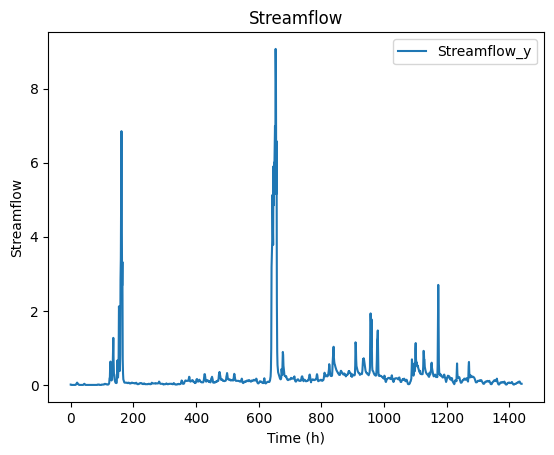

Network: 11
Streamflow (downstream) mean: 0.0
Streamflow (upstream) mean: 0.53


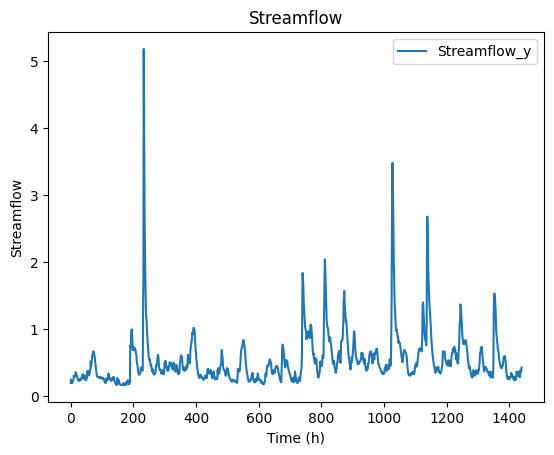

Network: 12
Streamflow (downstream) mean: 1.47
Streamflow (upstream) mean: 1.47


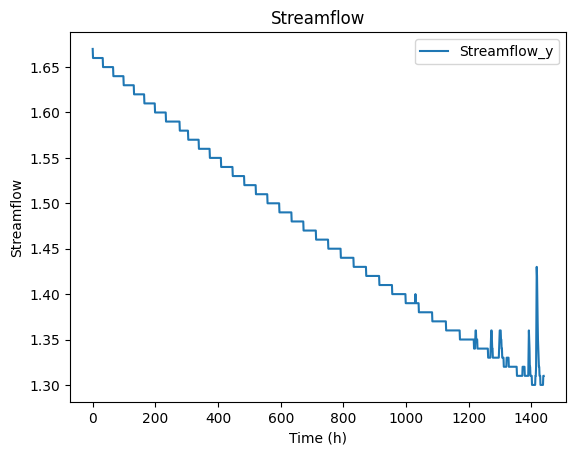

Network: 13
Streamflow (downstream) mean: 0.01
Streamflow (upstream) mean: 0.05


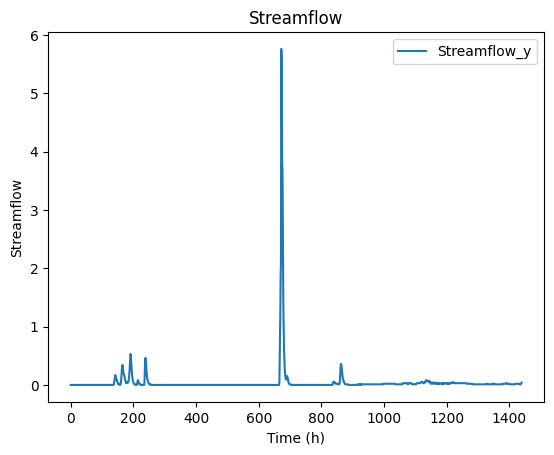

Network: 14
Streamflow (downstream) mean: 0.04
Streamflow (upstream) mean: 6.09


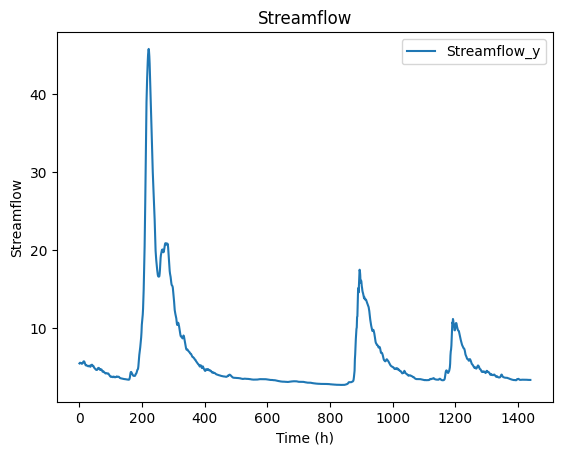

Network: 15
Streamflow (downstream) mean: 0.0
Streamflow (upstream) mean: 0.03


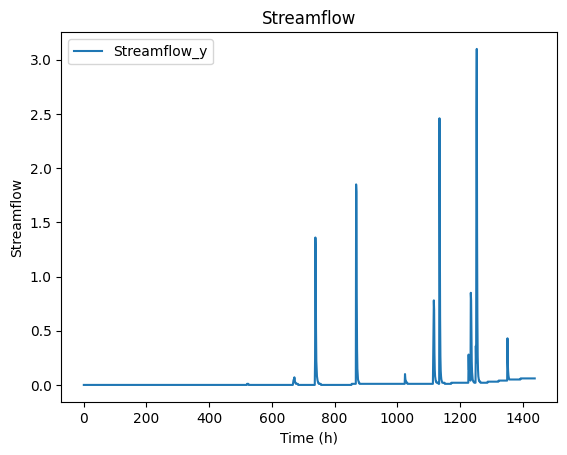

Network: 16
Streamflow (downstream) mean: 0.01
Streamflow (upstream) mean: 0.3


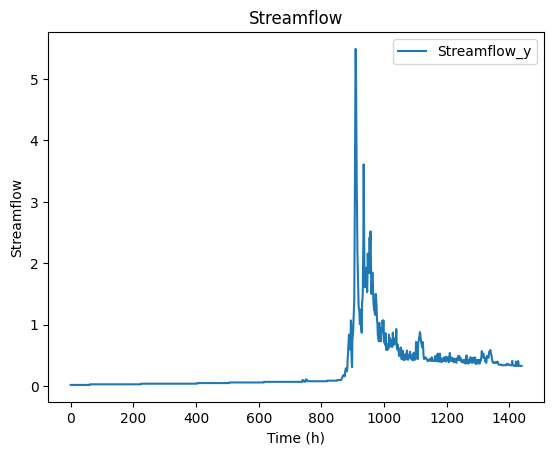

Network: 17
Streamflow (downstream) mean: 0.06
Streamflow (upstream) mean: 0.77


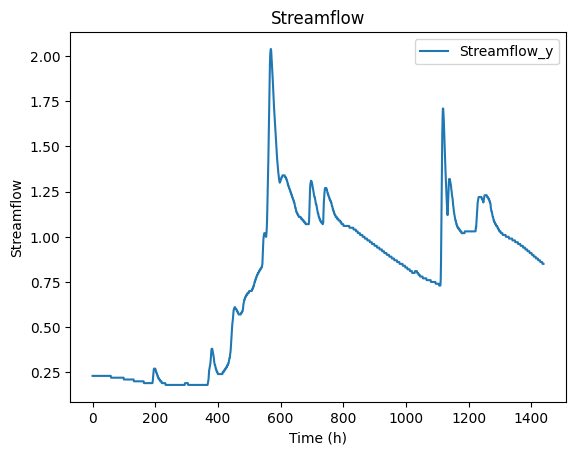

Network: 18
Streamflow (downstream) mean: 0.12
Streamflow (upstream) mean: 0.12


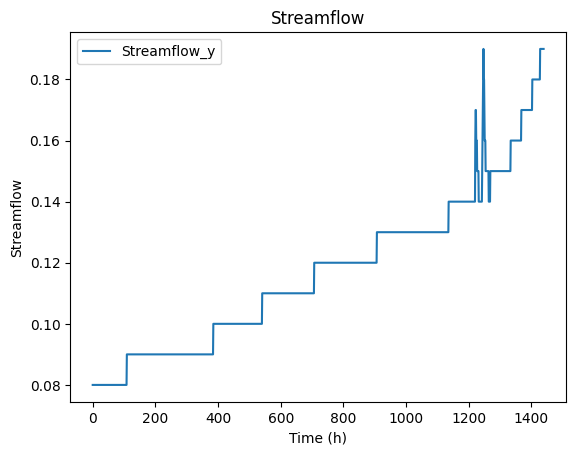

Network: 19
Streamflow (downstream) mean: 0.12
Streamflow (upstream) mean: 0.05


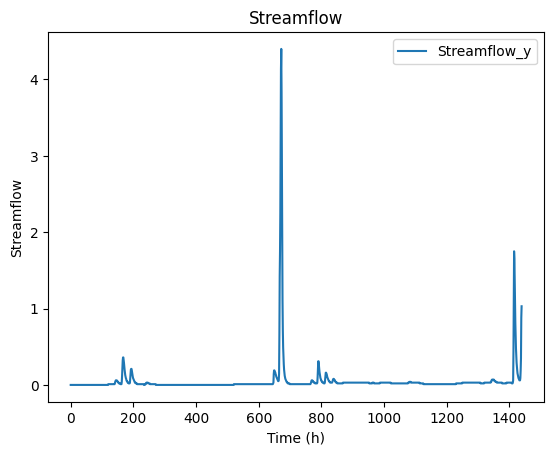

Network: 20
Streamflow (downstream) mean: 0.0
Streamflow (upstream) mean: 0.01


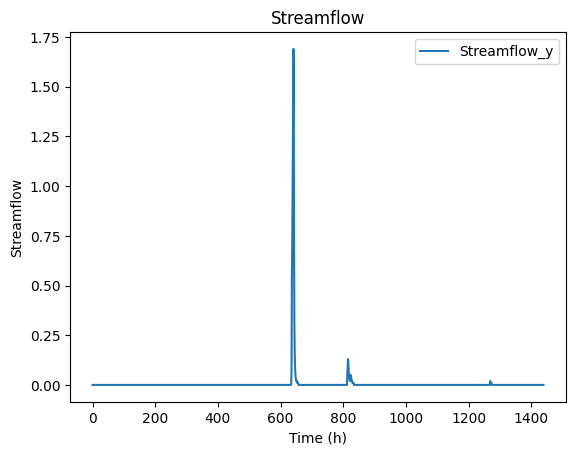

Network: 21
Streamflow (downstream) mean: 0.28
Streamflow (upstream) mean: 0.03


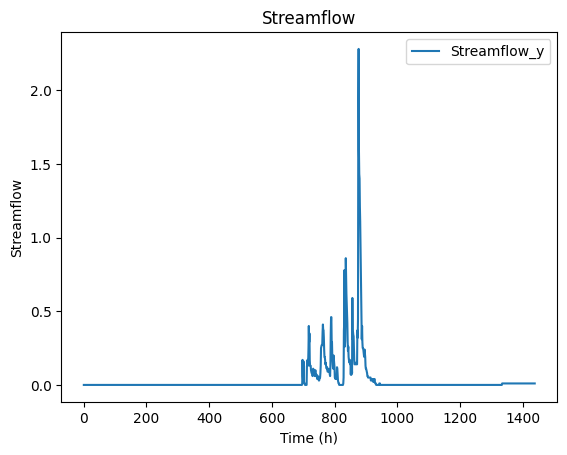

Network: 22
Streamflow (downstream) mean: 1.97
Streamflow (upstream) mean: 0.58


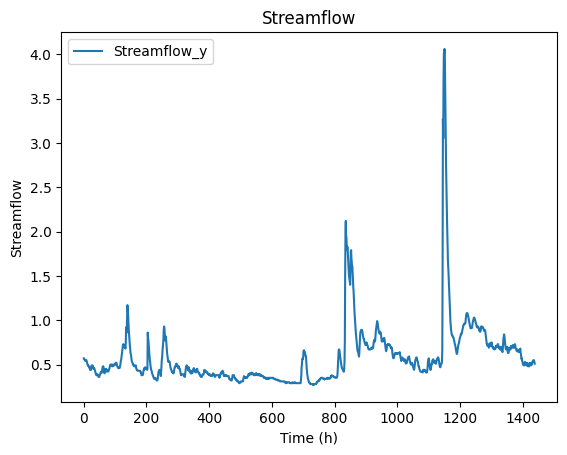

Network: 23
Streamflow (downstream) mean: 0.02
Streamflow (upstream) mean: 0.02


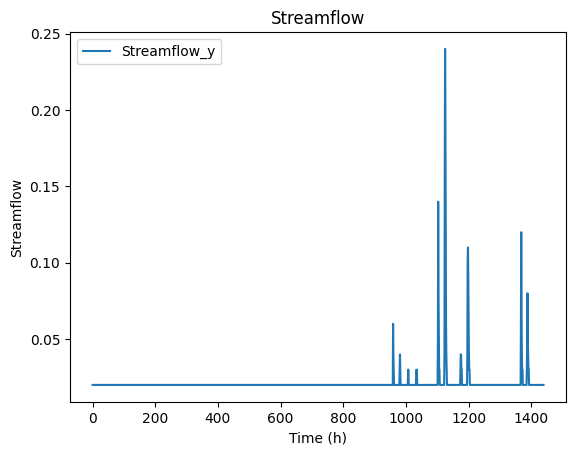

Network: 24
Streamflow (downstream) mean: 8.55
Streamflow (upstream) mean: 4.79


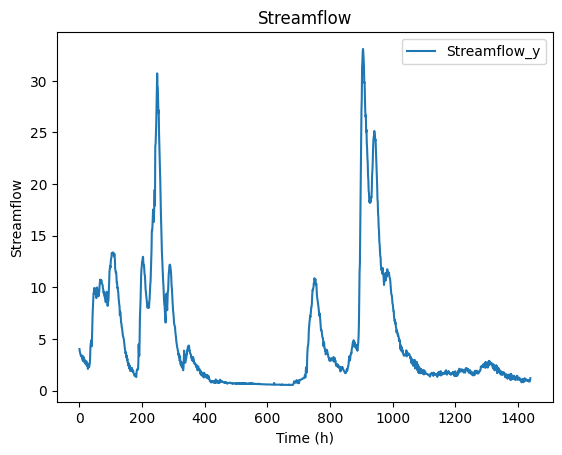

Network: 25
Streamflow (downstream) mean: 0.43
Streamflow (upstream) mean: 0.24


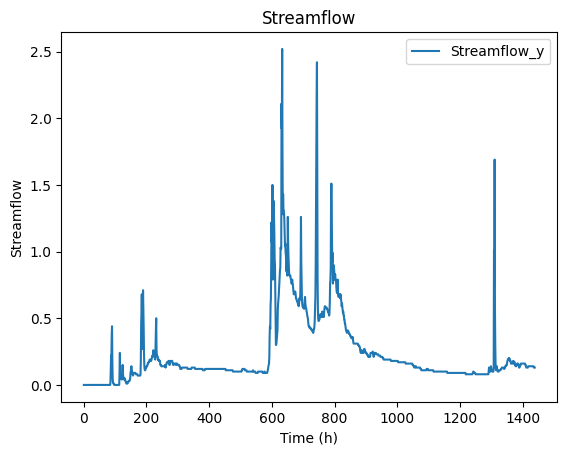

Network: 26
Streamflow (downstream) mean: 14.92
Streamflow (upstream) mean: 0.05


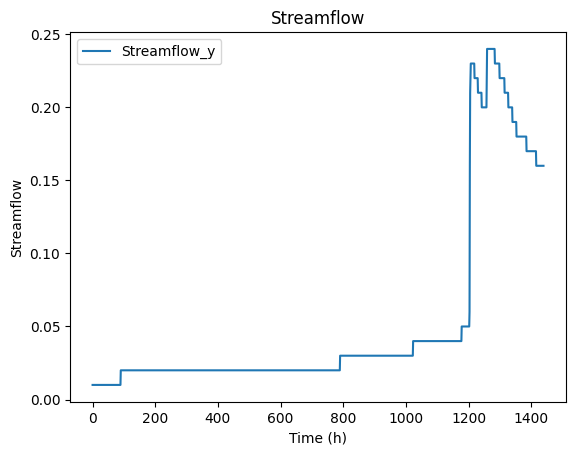

Network: 27
Streamflow (downstream) mean: 0.01
Streamflow (upstream) mean: 0.43


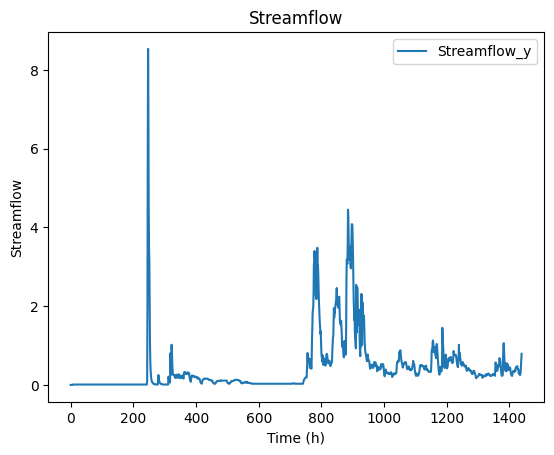

Network: 28
Streamflow (downstream) mean: 0.42
Streamflow (upstream) mean: 0.07


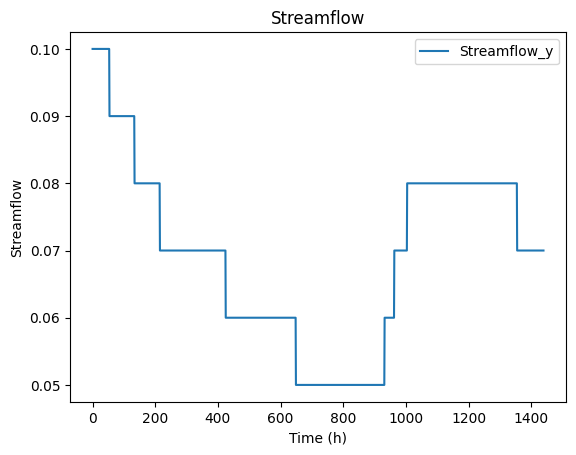

Network: 29
Streamflow (downstream) mean: 16.23
Streamflow (upstream) mean: 1.07


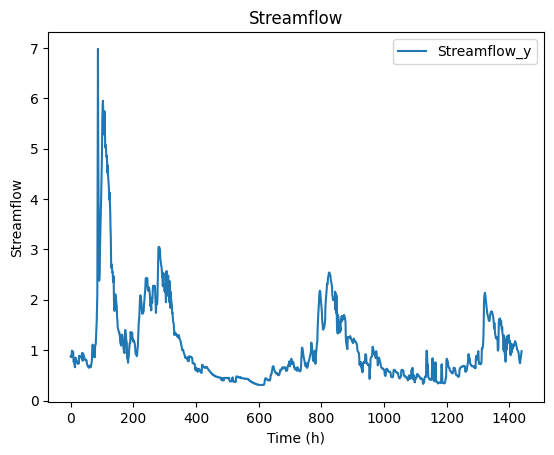

Network: 30
Streamflow (downstream) mean: 0.22
Streamflow (upstream) mean: 0.01


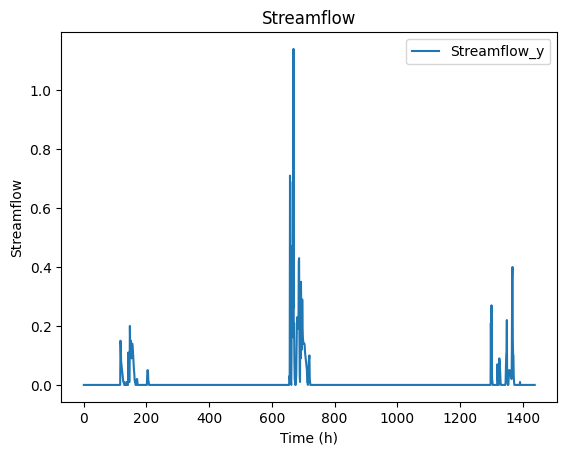

Network: 31
Streamflow (downstream) mean: 4.79
Streamflow (upstream) mean: 0.04


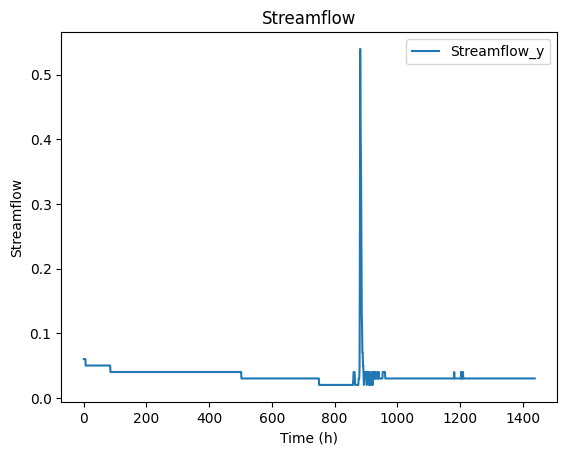

Network: 32
Streamflow (downstream) mean: 0.54
Streamflow (upstream) mean: 0.11


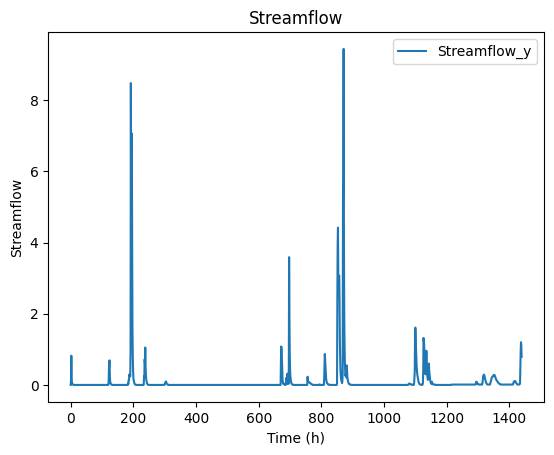

Network: 33
Streamflow (downstream) mean: 0.02
Streamflow (upstream) mean: 0.0


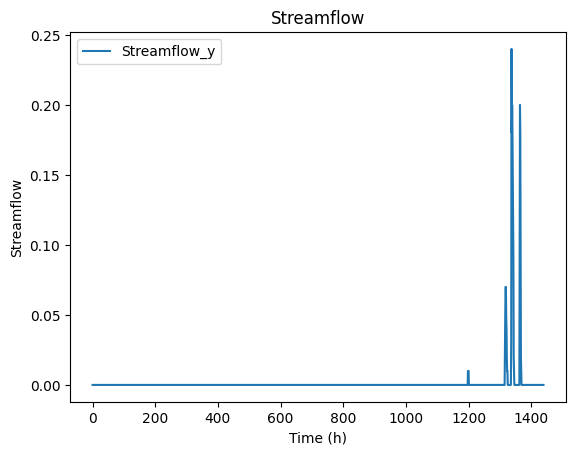

Network: 34
Streamflow (downstream) mean: 0.05
Streamflow (upstream) mean: 0.62


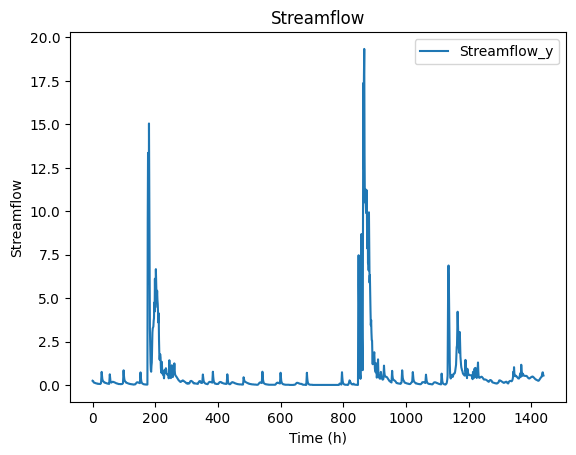

Network: 35
Streamflow (downstream) mean: 0.08
Streamflow (upstream) mean: 0.07


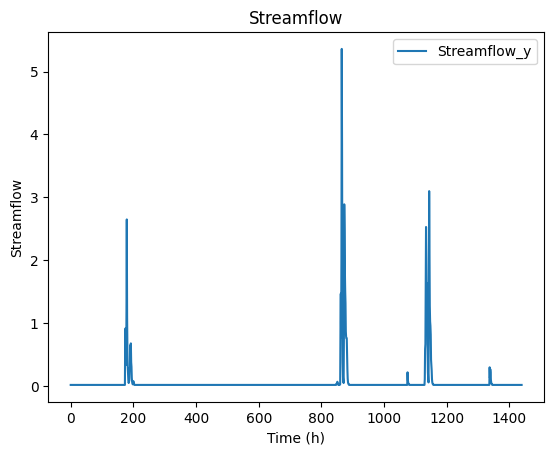

Network: 36
Streamflow (downstream) mean: 0.54
Streamflow (upstream) mean: 0.1


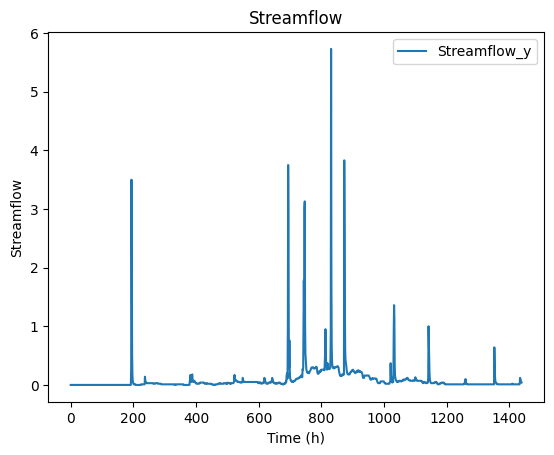

Network: 37
Streamflow (downstream) mean: 21.21
Streamflow (upstream) mean: 2.49


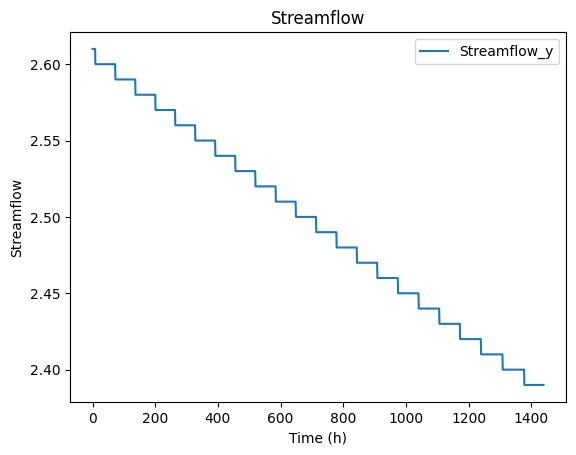

Network: 38
Streamflow (downstream) mean: 0.37
Streamflow (upstream) mean: 0.58


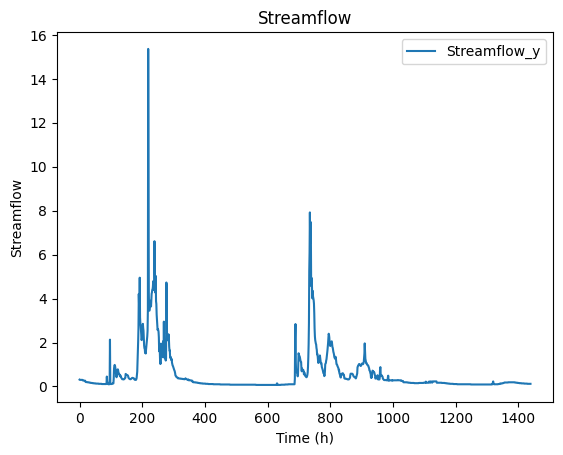

Network: 39
Streamflow (downstream) mean: 0.18
Streamflow (upstream) mean: 0.36


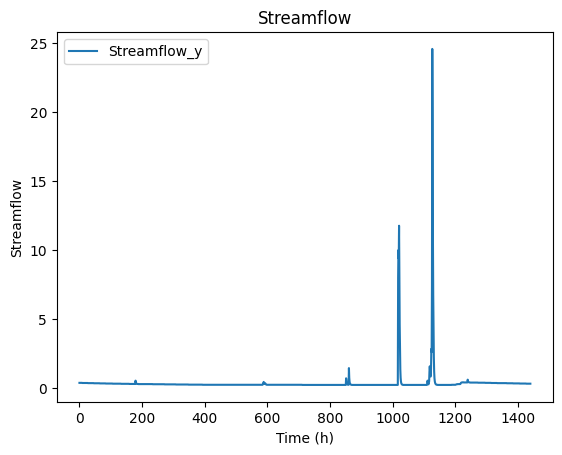

Network: 40
Streamflow (downstream) mean: 0.0
Streamflow (upstream) mean: 1.32


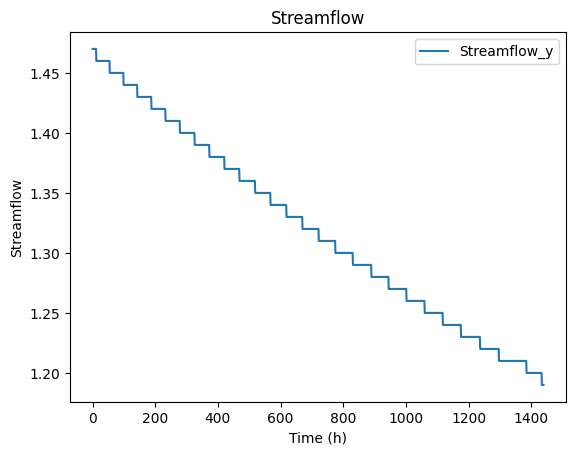

Network: 41
Streamflow (downstream) mean: 0.09
Streamflow (upstream) mean: 0.31


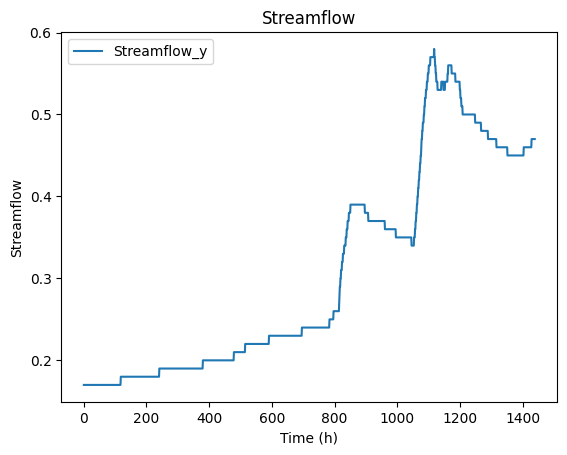

Network: 42
Streamflow (downstream) mean: 0.0
Streamflow (upstream) mean: 0.02


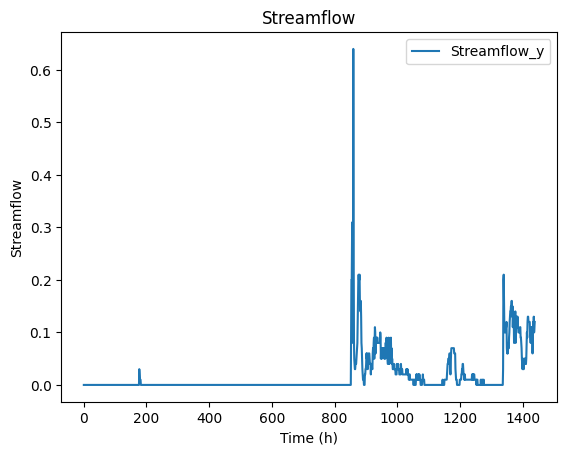

Network: 43
Streamflow (downstream) mean: 0.15
Streamflow (upstream) mean: 0.01


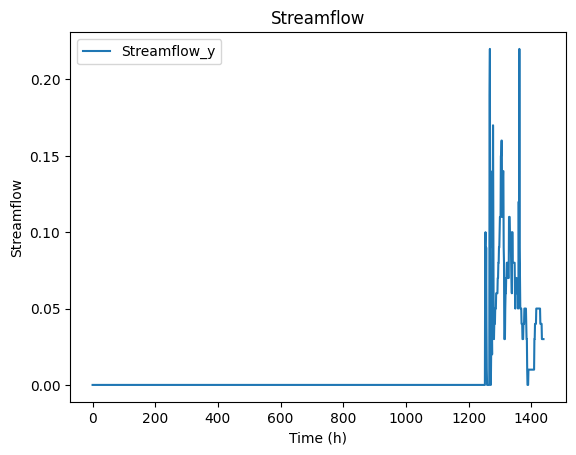

Network: 44
Streamflow (downstream) mean: 1.41
Streamflow (upstream) mean: 9.85


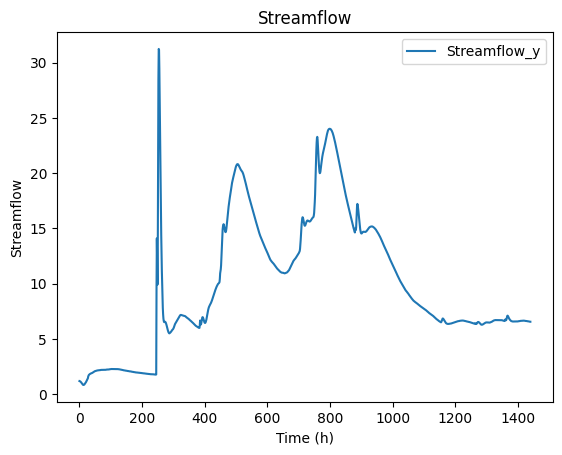

Network: 45
Streamflow (downstream) mean: 0.3
Streamflow (upstream) mean: 0.09


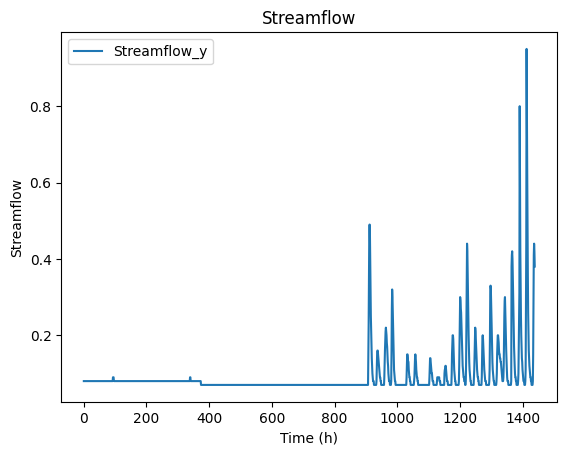

Network: 46
Streamflow (downstream) mean: 39.8
Streamflow (upstream) mean: 0.08


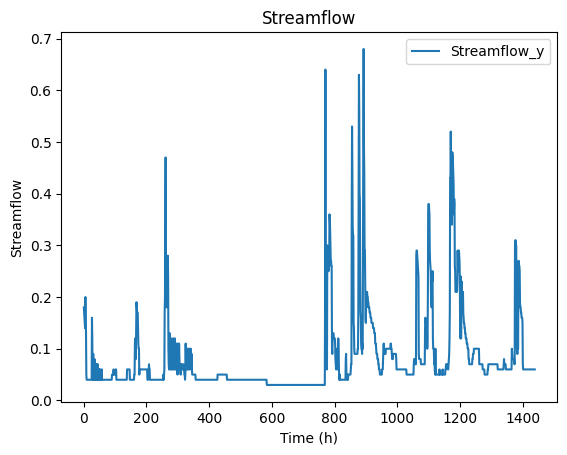

Network: 47
Streamflow (downstream) mean: 2.36
Streamflow (upstream) mean: 0.45


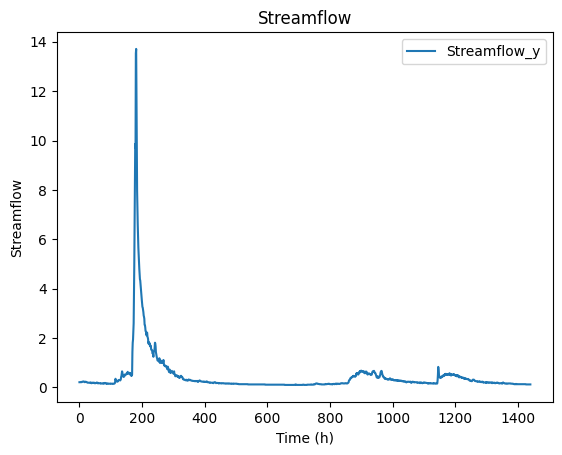

Network: 48
Streamflow (downstream) mean: 0.1
Streamflow (upstream) mean: 1.87


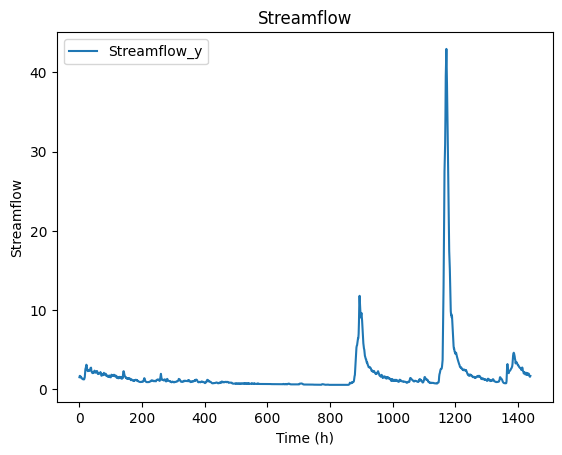

Network: 49
Streamflow (downstream) mean: 0.06
Streamflow (upstream) mean: 0.0


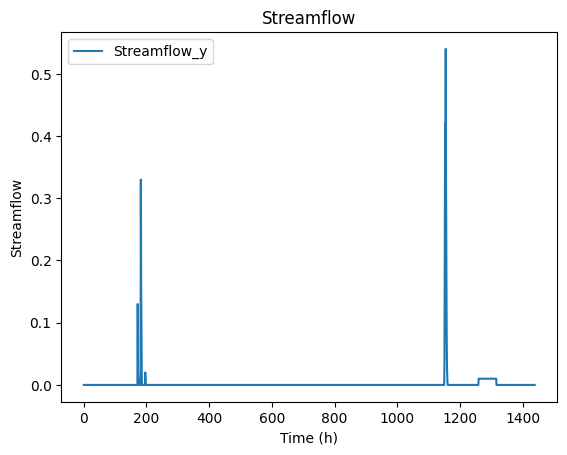

Network: 112
Streamflow (downstream) mean: 1.26
Streamflow (upstream) mean: 0.04


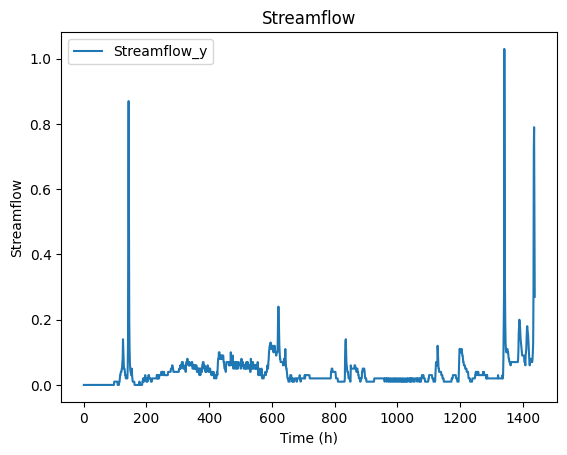

Network: 113
Streamflow (downstream) mean: 1.13
Streamflow (upstream) mean: 0.19


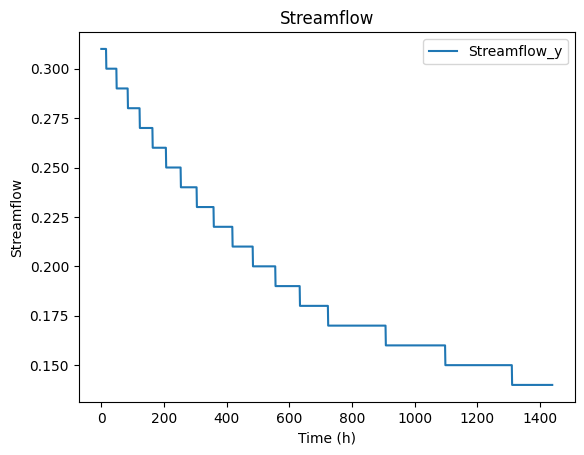

Network: 114
Streamflow (downstream) mean: 0.74
Streamflow (upstream) mean: 0.39


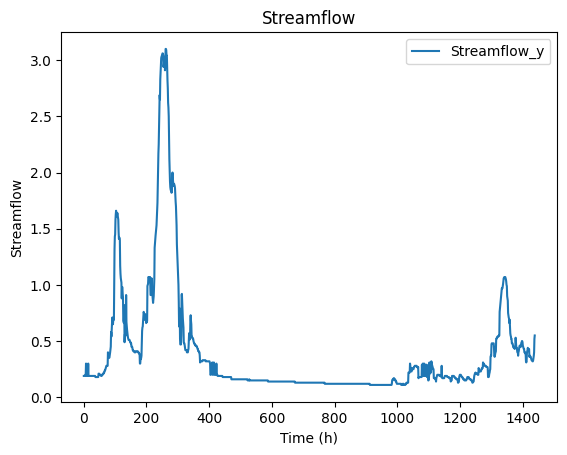

Network: 115
Streamflow (downstream) mean: 0.01
Streamflow (upstream) mean: 0.03


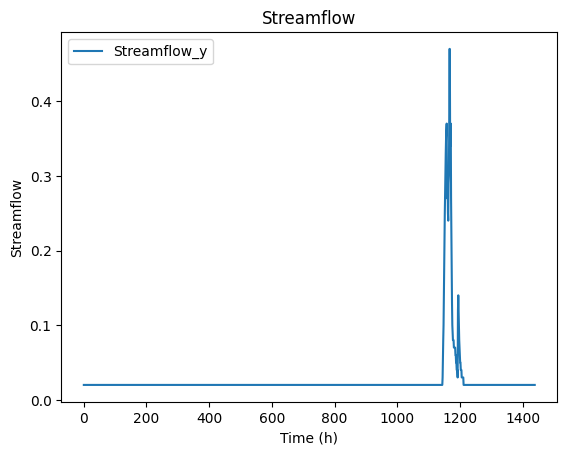

Network: 116
Streamflow (downstream) mean: 885.39
Streamflow (upstream) mean: 0.02


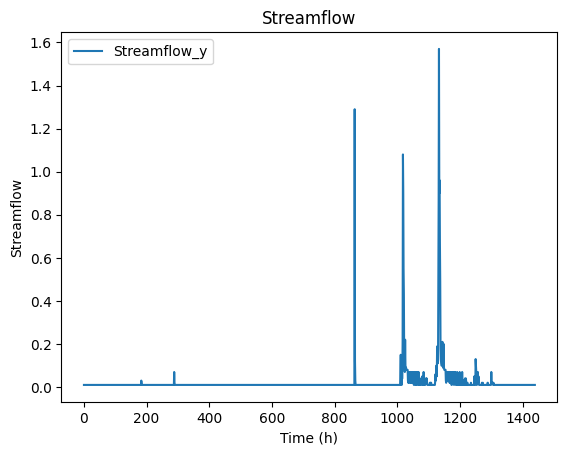

Network: 117
Streamflow (downstream) mean: 289.69
Streamflow (upstream) mean: 289.5


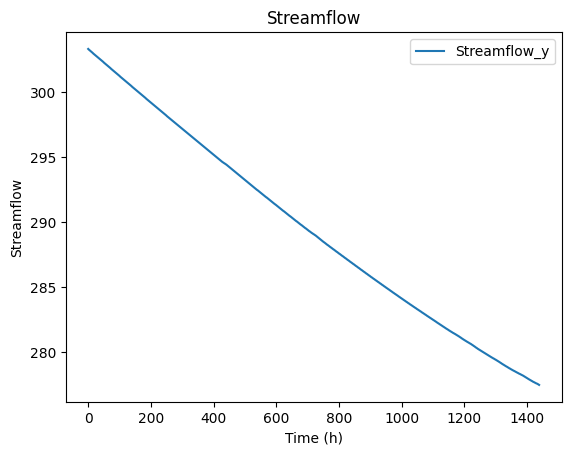

Network: 118
Streamflow (downstream) mean: 1.51
Streamflow (upstream) mean: 0.06


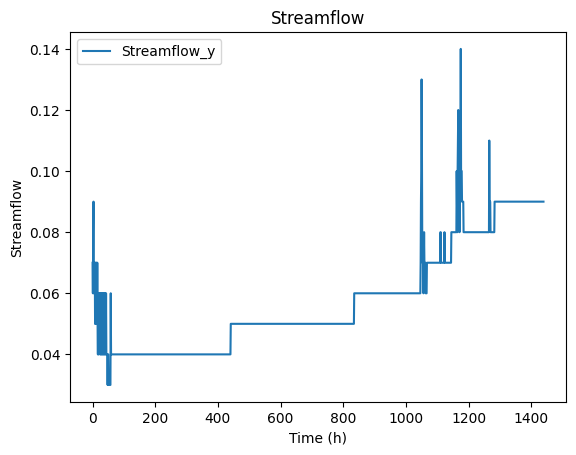

Network: 119
Streamflow (downstream) mean: 0.0
Streamflow (upstream) mean: 0.1


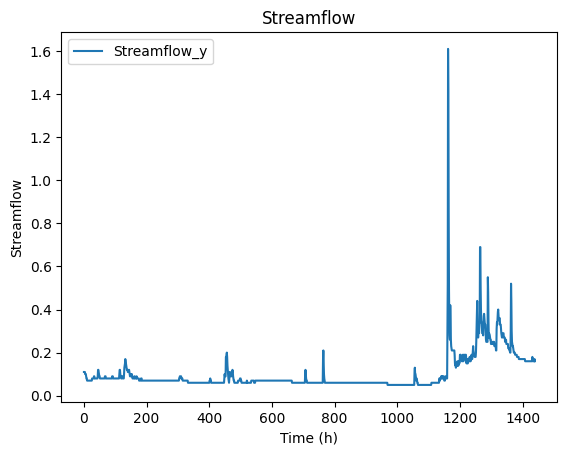

Network: 120
Streamflow (downstream) mean: 0.75
Streamflow (upstream) mean: 0.04


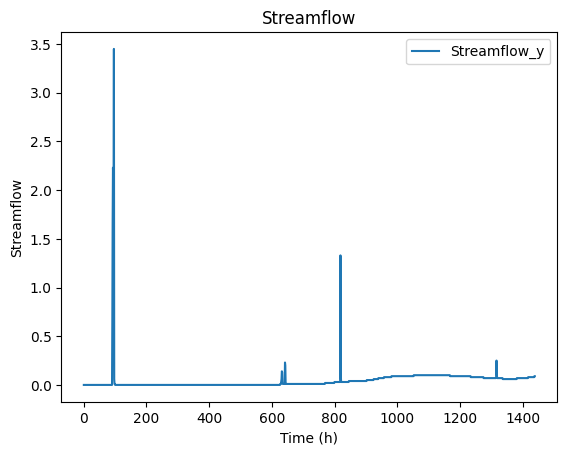

Network: 121
Streamflow (downstream) mean: 0.28
Streamflow (upstream) mean: 0.84


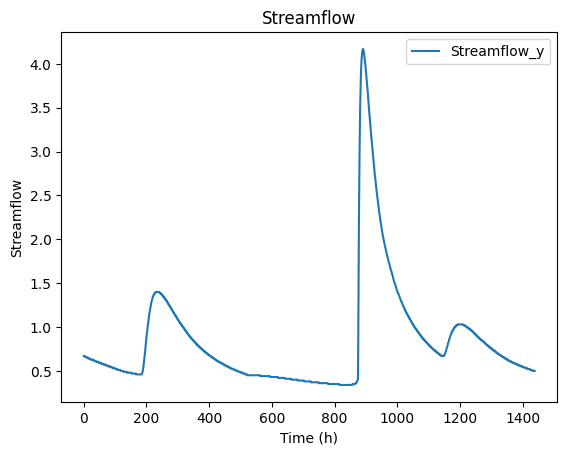

Network: 122
Streamflow (downstream) mean: 2.78
Streamflow (upstream) mean: 2.76


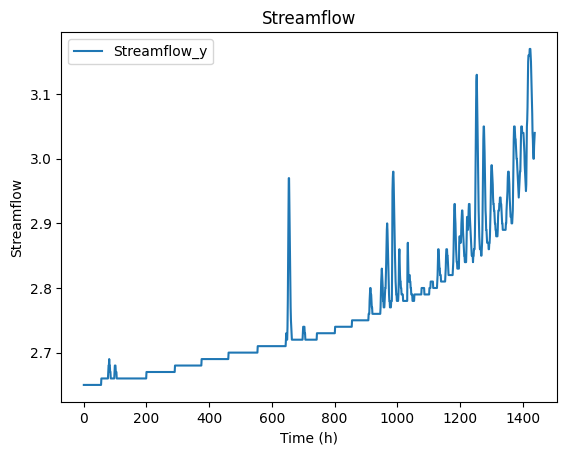

Network: 123
Streamflow (downstream) mean: 0.06
Streamflow (upstream) mean: 0.01


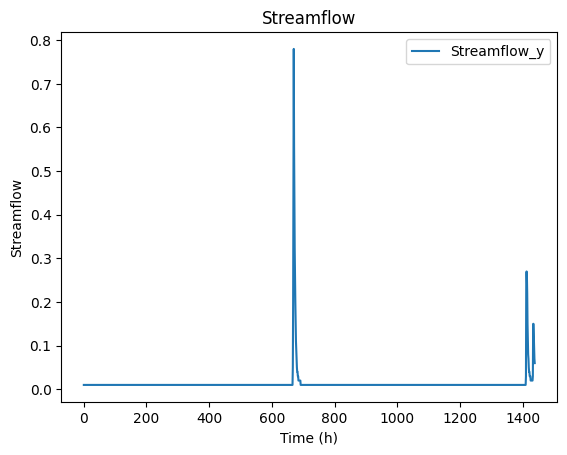

Network: 124
Streamflow (downstream) mean: 0.86
Streamflow (upstream) mean: 0.19


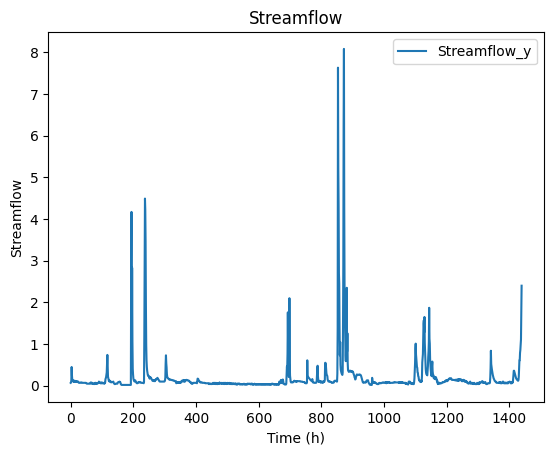

Network: 125
Streamflow (downstream) mean: 0.21
Streamflow (upstream) mean: 0.02


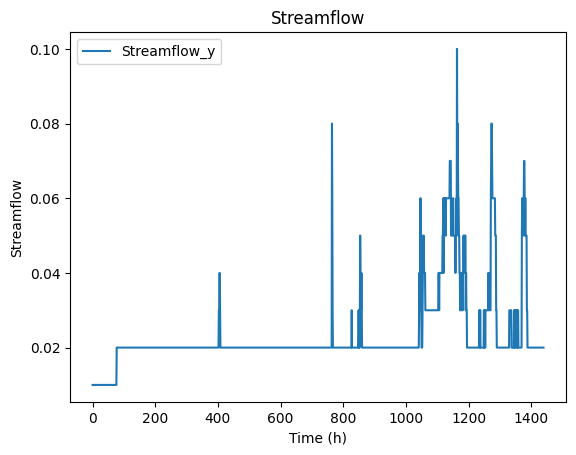

Network: 126
Streamflow (downstream) mean: 0.04
Streamflow (upstream) mean: 0.58


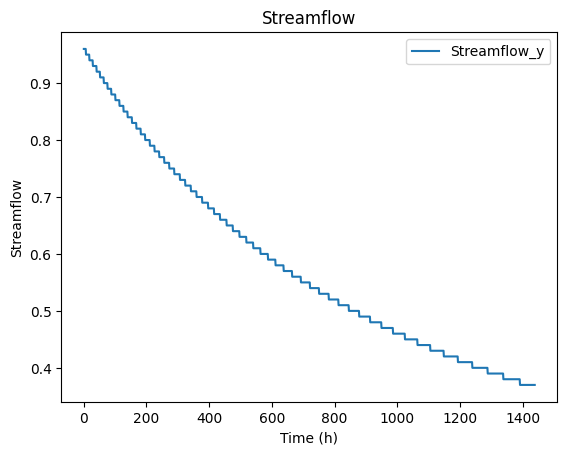

Network: 127
Streamflow (downstream) mean: 1.07
Streamflow (upstream) mean: 0.09


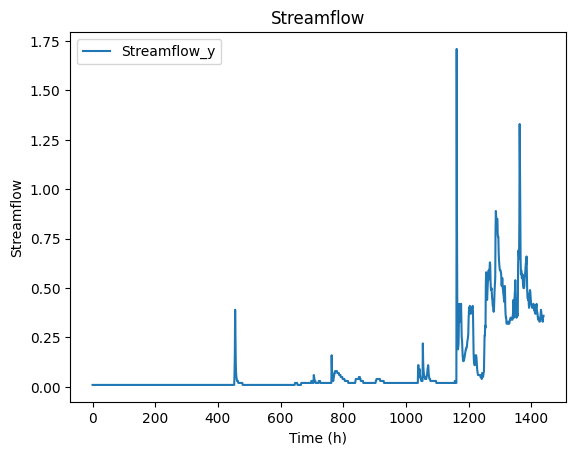

Network: 128
Streamflow (downstream) mean: 0.41
Streamflow (upstream) mean: 0.07


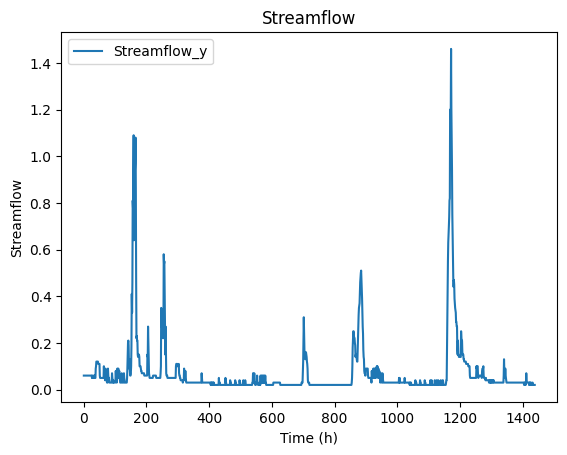

Network: 129
Streamflow (downstream) mean: 0.67
Streamflow (upstream) mean: 0.66


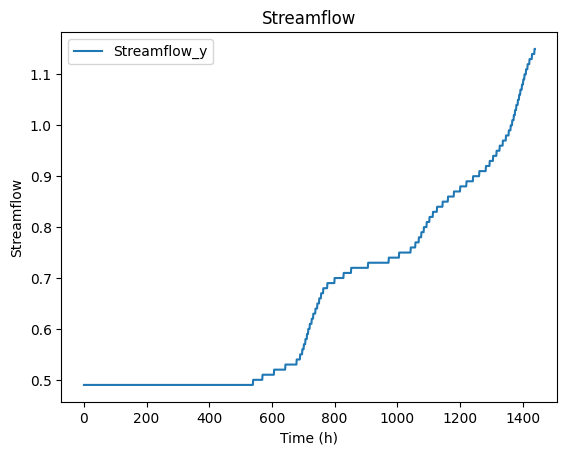

Network: 130
Streamflow (downstream) mean: 0.25
Streamflow (upstream) mean: 0.17


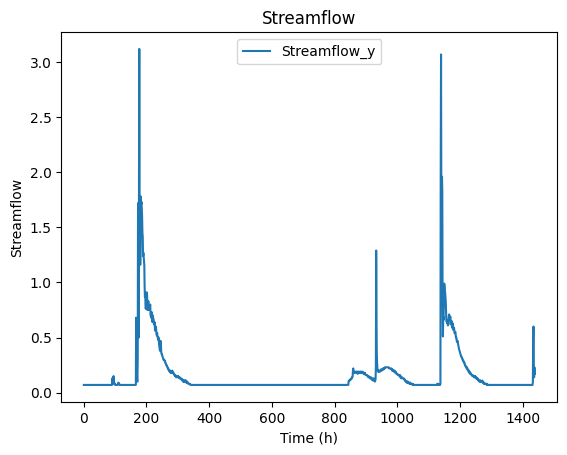

Network: 131
Streamflow (downstream) mean: 1.12
Streamflow (upstream) mean: 0.62


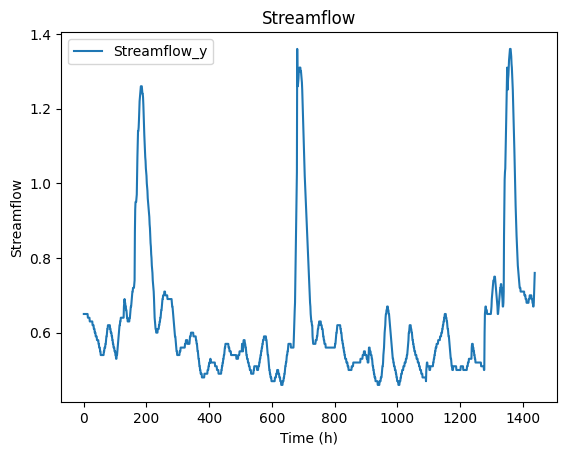

Network: 132
Streamflow (downstream) mean: 3.18
Streamflow (upstream) mean: 3.09


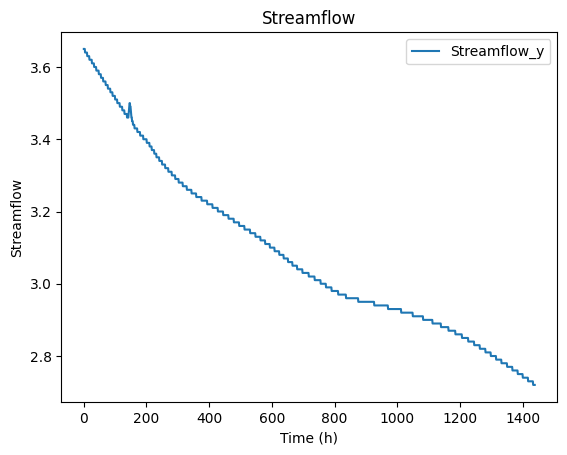

Network: 133
Streamflow (downstream) mean: 0.99
Streamflow (upstream) mean: 0.17


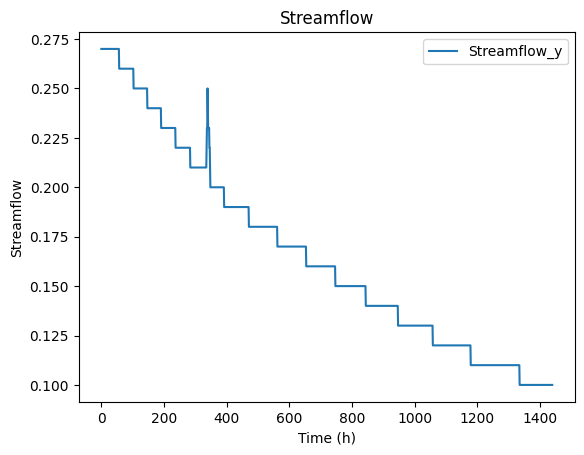

Network: 134
Streamflow (downstream) mean: 0.1
Streamflow (upstream) mean: 0.04


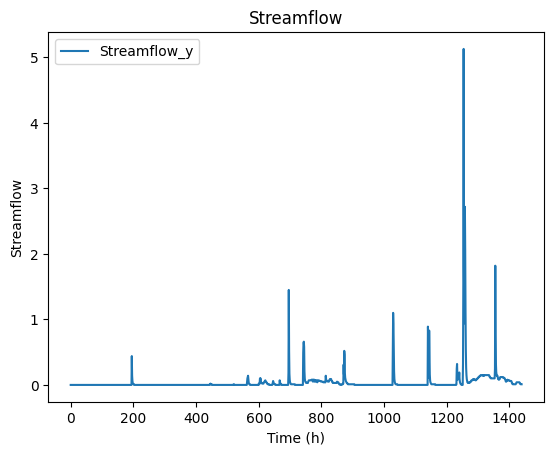

In [26]:
def viz_networks(ibuc):
    fig, ax = plt.subplots()
    print('Network:', ibuc)
    print("Streamflow (downstream) mean:", np.round(network_dict[ibuc].streamflow_x.mean(),2))
    print("Streamflow (upstream) mean:", np.round(network_dict[ibuc].streamflow_y.mean(),2))

    # network_dict[ibuc].loc[:2000,['precip_rate_x']].plot(ax=ax, legend=False)
    network_dict[ibuc].loc[:2000,['streamflow_y']].plot(ax=ax, legend=False)
    # network_dict[ibuc].loc[:2000,['APCP_surface_y']].plot(ax=ax, legend=False)
    # network_dict[ibuc].loc[:2000,['streamflow_x']].plot(ax=ax, legend=False)
    # network_dict[ibuc].loc[:2000,['APCP_surface_x']].plot(ax=ax, legend=False)
    ax.set_title('Streamflow')
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Streamflow')

    ax.legend(["Streamflow_y", "APCP_surface_x"])
    
    plt.show()
    plt.close()

def viz_networks2(ibuc):
    fig, ax1 = plt.subplots()
    print('Network:', ibuc)
    print("Streamflow (downstream) mean:", np.round(network_dict[ibuc].streamflow_x.mean(), 2))
    print("Streamflow (upstream) mean:", np.round(network_dict[ibuc].streamflow_y.mean(), 2))

    # Plot streamflow_y on the primary y-axis
    network_dict[ibuc].loc[:2000, ['streamflow_x']].plot(ax=ax1, color = 'blue', legend=False)
    network_dict[ibuc].loc[:2000, ['streamflow_y']].plot(ax=ax1, color = 'purple', legend=False)
    ax1.set_title('Streamflow and Precipitation')
    ax1.set_xlabel('Time (h)')
    ax1.set_ylabel('Streamflow')
    
    # Create a secondary y-axis and plot APCP_surface_x on it
    ax2 = ax1.twinx()
    network_dict[ibuc].loc[:2000, ['APCP_surface_x']].plot(ax=ax2, color='orange', legend=False)
    
    network_dict[ibuc].loc[:2000, ['APCP_surface_y']].plot(ax=ax2, color='red', legend=False)
    ax2.set_ylabel('APCP Surface')
    
    # Add legends for each axis
    ax1.legend(["Streamflow_y"], loc='upper left')
    ax2.legend(["APCP_surface_x"], loc='upper right')
    
    plt.show()
    plt.close()

    

displayed = 0

for ibuc in networks_for_training:
    viz_networks(ibuc)
    displayed += 1


for ibuc in networks_for_val:
    viz_networks(ibuc)
    displayed += 1

In [27]:


class LSTM1(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size

        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=128, batch_first=True)
        self.dropout1 = nn.Dropout(0.4)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, batch_first=True)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.4)
        self.normalization1 = nn.BatchNorm1d(256)
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(256, 128, bias=True),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64, bias = True),
            nn.ReLU(),
            nn.Linear(64, num_classes, bias=True)
        )

    def forward(self, x):
        out, _= self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = out[:,-1, :]
        out = self.normalization1(out)

        prediction = self.fc(out)
        return prediction



In [28]:

model = LSTM1(input_size=n_input, num_classes=n_output).to(device)
# model.load_state_dict(torch.load("model_weights_0.pth"))

In [29]:
def fit_scaler():
    frames = [network_dict[ibuc].loc[:, lstm_inputs] for ibuc in networks_for_training]
    df_in = pd.concat(frames)   
    print(df_in.shape)
    scaler_in = StandardScaler()
    scaler_in.fit(df_in)

    frames = [network_dict[ibuc].loc[:, lstm_outputs] for ibuc in networks_for_training]
    df_out = pd.concat(frames)    
    print(df_out.shape)
    scaler_out = StandardScaler()
    scaler_out.fit(df_out)
    return scaler_in, scaler_out

In [30]:
scaler_in, scaler_out = fit_scaler()

(57600, 33)
(57600, 1)


In [31]:
def make_data_loader(network_list):
    loader = {}
    np_seq_X = {}
    np_seq_y = {}
    for ibuc in network_list:
        df = network_dict[ibuc]
        scaler_in_i = scaler_in.transform(df.loc[:, lstm_inputs])
        scaler_out_i = scaler_out.transform(df.loc[:, lstm_outputs])
        
        n_samples = scaler_in_i.shape[0] - seq_length
        
        np_seq_X[ibuc] = np.zeros((n_samples, seq_length, n_input))
        np_seq_y[ibuc] = np.zeros((n_samples, n_output)) 

        for i in range(n_samples):
            t = i + seq_length
            np_seq_X[ibuc][i, :, :] = scaler_in_i[i:t, :]
            np_seq_y[ibuc][i, :] = scaler_out_i[t, :]

        ds = [torch.Tensor(np_seq_X[ibuc]), torch.Tensor(np_seq_y[ibuc])]
        loader[ibuc] = ds
    return loader, np_seq_X, np_seq_y

In [32]:
train_loader, np_train_seq_X, np_train_seq_y = make_data_loader(networks_for_training)
val_loader, np_val_seq_X, np_val_seq_y = make_data_loader(networks_for_val)
test_loader, np_test_seq_X, np_test_seq_y = make_data_loader(networks_for_test)

In [33]:
##Train-Loader A dictionary of training buckets, where each element of dictionary has respective x and y values of that bucket and each x value is a 3d vector (Data points, time steps, features)


print(len(train_loader))
print(f"Each network has {train_loader[networks_for_training[0]][0].shape[0]} data points")
print(f"Each data point is made up of sequence of {train_loader[networks_for_training[0]][0].shape[1]} timesteps")
print(f"Each time step has {train_loader[networks_for_training[0]][0].shape[2]} features.")

40
Each network has 890 data points
Each data point is made up of sequence of 550 timesteps
Each time step has 33 features.


In [34]:
def concatanate_tensors(loader,  networks):
    concatanated_tensor_x = loader[networks[0]][0]
    concatanated_tensor_y = loader[networks[0]][1]

    for i in range(len(networks) - 1):
        concatanated_tensor_x = torch.cat((concatanated_tensor_x, loader[networks[i+1]][0]))
        concatanated_tensor_y = torch.cat((concatanated_tensor_y, loader[networks[i+1]][1]))
    return concatanated_tensor_x, concatanated_tensor_y    

In [35]:
train_data_x, train_data_y = concatanate_tensors(train_loader, networks_for_training)
val_data_x, val_data_y = concatanate_tensors(val_loader, networks_for_val)
test_data_x, test_data_y = concatanate_tensors(test_loader, networks_for_test)

In [36]:
print(f"After concatenating data of every bucket in training, now the total data points we have is going to be {train_data_x.shape[0]}")

After concatenating data of every bucket in training, now the total data points we have is going to be 35600


In [37]:
# batch_size = train_data_y.shape[0]
# batch_size = int (train_data_y.shape[0]/3)
batch_size = 2048
train_dataset = torch.utils.data.TensorDataset(train_data_x, train_data_y)
train_batch_loader = torch.utils.data.DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(val_data_x, val_data_y)
val_batch_loader = torch.utils.data.DataLoader(val_dataset, batch_size= batch_size)
test_dataset = torch.utils.data.TensorDataset(test_data_x, test_data_y)
test_batch_loader = torch.utils.data.DataLoader(test_dataset, batch_size= batch_size)
print(f"The batch size selected is {batch_size}.")

The batch size selected is 2048.


In [38]:
def inverse_scale(scaler, numpy_value):
    transformed_numpy_value = scaler.inverse_transform(numpy_value)
    return transformed_numpy_value


In [39]:
def calculate_NSE(observed_value, modeled_value):
    mean_observed_value = np.mean(observed_value)
    numerator = np.sum(np.power((observed_value - modeled_value), 2))
    denominator = np.sum(np.power((observed_value - mean_observed_value), 2))
    return round((1 - (numerator/denominator)), 2) 

In [40]:
class EarlyStopper:
    def __init__(self, patience= 5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
class EarlyStopperNSE:
    def __init__(self, patience= 5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_NSE = -100000000
    
    def early_stop(self, NSE):
        if (NSE >= self.max_NSE):
            self.max_NSE = NSE
            self.counter = 0
        elif NSE <= (self.max_NSE - self.min_delta):
            self.counter += 1
            if(self.counter) >= self.patience:
                return True
        return False

In [41]:
early_stopper = EarlyStopper(patience = 15, min_delta= 0.001)
early_stopper_NSE = EarlyStopperNSE(patience = 15, min_delta = 0.05)

In [42]:
def train_model(lstm, train_batch_loader):
    criterion = nn.MSELoss()
    # optimizer = optim.SGD(lstm.parameters(), lr = 0.01, momentum=0.7, weight_decay = 0.09)
    optimizer = optim.AdamW(lstm.parameters(), lr= 0.001, weight_decay = 0.09)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 10, factor = 0.8)
    epochs = 200
    loss_history_train = []
    loss_history_val = []
    NSE_train = []
    NSE_val = []
    for epoch in range(epochs):
        lstm.train()
        NSE_batch_train = []
        NSE_batch_val = []
        for data, targets in train_batch_loader:
            loss_history_train_epoch = []
            loss_history_val_epoch = []
            x = data.to(device=device)
            y = targets.to(device=device)

            optimizer.zero_grad()
            predicted_y = lstm(x)
            loss = criterion(predicted_y, y)

            loss_history_train_epoch.append(loss.item())
            loss.backward()
            optimizer.step()
         
            with torch.no_grad():
                y_calc =  y.to("cpu").numpy()
                y_calc = inverse_scale(scaler_out, y_calc)
                y_calc = y_calc.reshape(y_calc.shape[0])

                predicted_y_calc =  predicted_y.to("cpu").numpy()      
                predicted_y_calc = inverse_scale(scaler_out, predicted_y_calc)
                predicted_y_calc = predicted_y_calc.reshape(y_calc.shape[0])

                NSE_batch_train.append(calculate_NSE(y_calc, predicted_y_calc))

                
        lstm.eval()
        with torch.no_grad():
            for data, targets in val_batch_loader:
                x_calc = data.to(device=device)
                y_calc = targets.to(device=device)
                predicted_y_calc = lstm(x_calc)
                loss_calc = criterion(predicted_y_calc, y_calc)
                loss_history_val_epoch.append(loss_calc.item())

                y_calc =  y_calc.to("cpu").numpy()
                y_calc = inverse_scale(scaler_out, y_calc)
                y_calc = y_calc.reshape(y_calc.shape[0])

                predicted_y_calc =  predicted_y_calc.to("cpu").numpy()
                predicted_y_calc = inverse_scale(scaler_out, predicted_y_calc)
                predicted_y_calc = predicted_y_calc.reshape(y_calc.shape[0])

                NSE_batch_val.append(calculate_NSE(y_calc, predicted_y_calc))
                
            # if early_stopper.early_stop(np.mean(loss_history_val_epoch)) and epoch > 35:
            #     break

        scheduler.step(loss_calc)
        loss_history_train.append(np.mean(loss_history_train_epoch))
        loss_history_val.append(np.mean(loss_history_val_epoch))
        NSE_val.append(np.mean(NSE_batch_val))
        NSE_train.append(np.mean(NSE_batch_train))

        print(f"Epoch: {epoch + 1} Completed\tLoss_Train: {loss_history_train[-1]:.4f}\tNSE_Train: {np.mean(NSE_batch_train):.4f}\tLoss_Val: {loss_history_val[-1]:.4f}\tNSE_Validation:{np.mean(NSE_batch_val):.4f}\t Learning_Rate: {optimizer.param_groups[0]['lr']})")
        

    return lstm, loss_history_train, loss_history_val, NSE_train, NSE_val

In [43]:
model, loss_history_train, loss_history_val, NSE_train, NSE_val = train_model(model, train_batch_loader)

Epoch: 1 Completed	Loss_Train: 0.6152	NSE_Train: 0.2933	Loss_Val: 507.7487	NSE_Validation:-9.3360	 Learning_Rate: 0.001)
Epoch: 2 Completed	Loss_Train: 0.1754	NSE_Train: 0.6806	Loss_Val: 495.8469	NSE_Validation:-43.4660	 Learning_Rate: 0.001)
Epoch: 3 Completed	Loss_Train: 0.1398	NSE_Train: 0.7561	Loss_Val: 475.4247	NSE_Validation:-127.9660	 Learning_Rate: 0.001)


Epoch: 4 Completed	Loss_Train: 0.3980	NSE_Train: 0.7794	Loss_Val: 437.2882	NSE_Validation:-631.0800	 Learning_Rate: 0.001)
Epoch: 5 Completed	Loss_Train: 0.1426	NSE_Train: 0.8144	Loss_Val: 436.3350	NSE_Validation:-653.2410	 Learning_Rate: 0.001)
Epoch: 6 Completed	Loss_Train: 0.1157	NSE_Train: 0.8383	Loss_Val: 410.2460	NSE_Validation:-1165.7750	 Learning_Rate: 0.001)
Epoch: 7 Completed	Loss_Train: 0.0936	NSE_Train: 0.8494	Loss_Val: 415.8379	NSE_Validation:-1183.1060	 Learning_Rate: 0.001)
Epoch: 8 Completed	Loss_Train: 0.0945	NSE_Train: 0.8883	Loss_Val: 415.9749	NSE_Validation:-1085.3630	 Learning_Rate: 0.001)
Epoch: 9 Completed	Loss_Train: 0.0821	NSE_Train: 0.8956	Loss_Val: 412.3197	NSE_Validation:-1184.0638	 Learning_Rate: 0.001)
Epoch: 10 Completed	Loss_Train: 0.1073	NSE_Train: 0.9050	Loss_Val: 385.1157	NSE_Validation:-1991.9109	 Learning_Rate: 0.001)
Epoch: 11 Completed	Loss_Train: 0.0604	NSE_Train: 0.8806	Loss_Val: 398.7414	NSE_Validation:-1558.2290	 Learning_Rate: 0.001)
Epoch: 1

KeyboardInterrupt: 

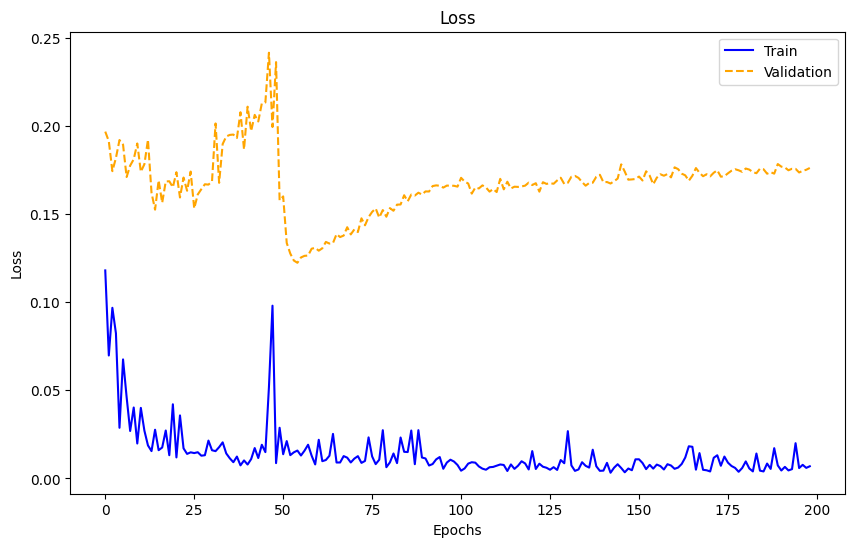

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history_train[1:], label='Train', color='blue')
plt.plot(loss_history_val[1:], label='Validation', color='orange', linestyle = '--')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

In [35]:
# print(NSE_val[:-10])

In [36]:
# import csv

# def save_last_10_values_and_avg_to_csv(NSE_train_value, NSE_val_value, output_csv_file):

#     # Ensure both lists have at least 10 values
#     if len(NSE_train_value) < 10 or len(NSE_val_value) < 10:
#         raise ValueError("Both lists must have at least 10 values.")
    
#     # Extract the last 10 values
#     last_10_train = NSE_train_value[-10:]
#     last_10_val = NSE_val_value[-10:]
    
#     # Compute averages
#     avg_train = sum(last_10_train) / 10
#     avg_val = sum(last_10_val) / 10
    
#     # Write the data to a CSV file
#     with open(output_csv_file, mode='w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
        
#         # Write headers
#         writer.writerow(["Metric", "Values", "Average"])
        
#         # Write last 10 values and average for training data
#         writer.writerow(["NSE_train_last_10", ", ".join(map(str, last_10_train)), avg_train])
        
#         # Write last 10 values and average for validation data
#         writer.writerow(["NSE_val_last_10", ", ".join(map(str, last_10_val)), avg_val])
    
#     print(f"Last 10 values and averages saved to {output_csv_file}")



# # Example usage:
# save_last_10_values_and_avg_to_csv(NSE_train, NSE_val, "Results/average_values_combined")

In [37]:
# val_loader, np_val_seq_X, np_val_seq_y = make_data_loader([3])  ##
plot_bucket = [115]
test_data_x, test_data_y = concatanate_tensors(val_loader, plot_bucket)
test_dataset = torch.utils.data.TensorDataset(test_data_x, test_data_y)
test_batch_loader = torch.utils.data.DataLoader(test_dataset, batch_size= batch_size)

In [ ]:
print(network_dict[0])
model.eval()
with torch.no_grad():
    test_data_x = test_data_x.to(device)
    predicted_y_untransformed = model(test_data_x)
    predicted_y_untransformed = predicted_y_untransformed.to("cpu").numpy()
    predicted_y = inverse_scale(scaler_out, predicted_y_untransformed)
    test_data_y = test_data_y.to("cpu").numpy()
    test_data_y = inverse_scale(scaler_out, test_data_y)


                time  comid_x      catid_x du_x  pair_id_x  U2D_x  V2D_x  \
0      1/1/2008 0:00  7516451  cat-2185351    d          7    3.6 -4.800   
1      1/1/2008 1:00  7516451  cat-2185351    d          7    3.4 -4.200   
2      1/1/2008 2:00  7516451  cat-2185351    d          7    3.1 -3.600   
3      1/1/2008 3:00  7516451  cat-2185351    d          7    2.9 -3.000   
4      1/1/2008 4:00  7516451  cat-2185351    d          7    3.0 -2.700   
..               ...      ...          ...  ...        ...    ...    ...   
739  1/31/2008 19:00  7516451  cat-2185351    d          7   -0.7 -4.835   
740  1/31/2008 20:00  7516451  cat-2185351    d          7   -0.6 -4.700   
741  1/31/2008 21:00  7516451  cat-2185351    d          7   -0.5 -4.600   
742  1/31/2008 22:00  7516451  cat-2185351    d          7   -0.6 -3.800   
743  1/31/2008 23:00  7516451  cat-2185351    d          7   -0.6 -3.100   

     LWDOWN_x  RAINRATE_x   T2D_x  ...  slope_mean_y  impervious_mean_y  \
0     198.47

In [39]:
x = []
test_data_y = test_data_y.reshape(test_data_y.shape[0])
predicted_y = predicted_y.reshape(predicted_y.shape[0])

print(calculate_NSE(test_data_y, predicted_y))
predicted_y = predicted_y.reshape(predicted_y.shape[0])

-2.87


In [40]:
# rain_rate  = network_dict[plot_bucket]['RAINRATE_x'][270:744].to_list()

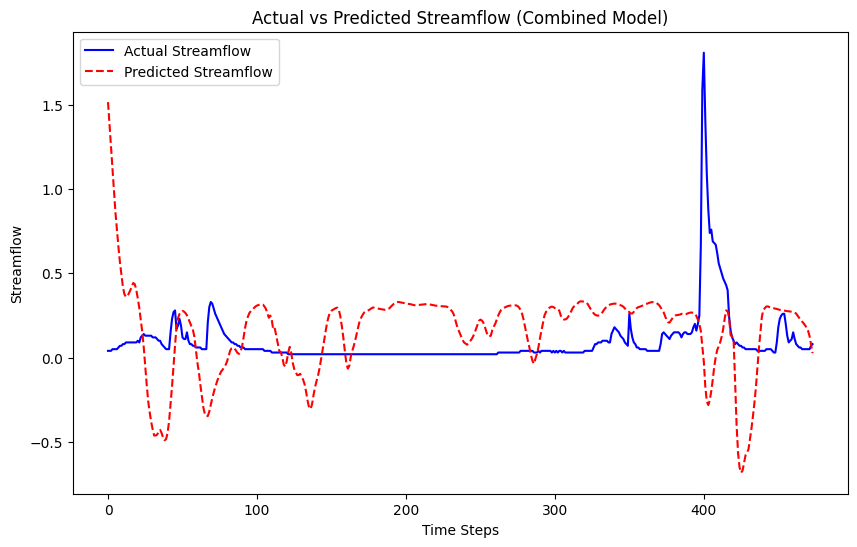

In [ ]:
import matplotlib.pyplot as plt

# Plot the actual and predicted streamflow values
plt.figure(figsize=(10, 6))
plt.plot(test_data_y, label='Actual Streamflow', color='blue')
plt.plot(predicted_y, label='Predicted Streamflow', color='red', linestyle='--')
# plt.plot(rain_rate, color='yellow', linestyle='--')

# Adding labels and title
plt.xlabel('Time Steps')
plt.ylabel('Streamflow')
plt.title('Actual vs Predicted Streamflow (Combined Model)')
plt.legend()


In [42]:
# import matplotlib.pyplot as plt

# # Create the figure and the primary axis
# fig, ax1 = plt.subplots(figsize=(10, 6))

# # Plot test_data_y (Actual Streamflow) on the primary y-axis
# ax1.plot(test_data_y, label='Actual Streamflow', color='blue')
# ax1.set_xlabel('Time Steps')
# ax1.set_ylabel('Streamflow (Actual)', color='blue')
# ax1.tick_params(axis='y', labelcolor='blue')
# ax1.set_title('Actual vs Predicted Streamflow with Rain Rate')
# ax1.legend(['Actual Streamflow'], loc='upper left')

# # Create a secondary y-axis for predicted_y
# ax2 = ax1.twinx()
# ax2.plot(predicted_y, label='Predicted Streamflow', color='red', linestyle='--')
# ax2.plot(rain_rate, label='Rain Rate', color='yellow', linestyle=':')
# ax2.set_ylabel('Streamflow (Predicted) and Rain Rate', color='red')
# ax2.tick_params(axis='y', labelcolor='red')
# ax2.legend(['Predicted Streamflow', 'Rain Rate'], loc='upper right')

plt.show()
